This file is for fire predition for the capstone project (group 4 : DELPHI)

# Fire Prediction

## Phase 1: EDA

We are first interested in the whole dataset, then we focus on the numerical features before focusing on the categorical features

In [1]:
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series, plot_lags
from statsmodels.graphics.tsaplots import plot_acf, month_plot, seasonal_plot, plot_predict
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.split import temporal_train_test_split
pio.templates.default = 'plotly_white'

In [2]:
df = pd.read_csv("fire_archive_SV-C2_422342.csv")

In [3]:
# First five rows of the dataframe
display(df.head())

latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0  1.895509  31.501383      367.00  0.60   0.53  2022-01-01      1148   
1  1.691601  34.326340      333.38  0.47   0.64  2022-01-01      1148   
2  1.690971  34.322052      367.00  0.47   0.64  2022-01-01      1148   
3  1.685041  34.322899      331.16  0.47   0.64  2022-01-01      1148   
4  1.675683  34.341782      335.44  0.47   0.64  2022-01-01      1148   

  satellite instrument confidence  version  bright_t31    frp daynight  type  
0         N      VIIRS          h        1      296.36  22.37        D     0  
1         N      VIIRS          n        1      291.38   6.77        D     0  
2         N      VIIRS          h        1      293.82   6.77        D     0  
3         N      VIIRS          n        1      292.69   6.77        D     0  
4         N      VIIRS          n        1      293.79   4.65        D     0

In [4]:
# Last five rows of the dataframe
display(df.tail())


latitude  longitude  brightness  scan  track    acq_date  acq_time  \
56364  1.262882  31.185347      341.00  0.42   0.38  2022-08-31      1106   
56365  1.101329  32.310097      330.40  0.39   0.36  2022-08-31      1106   
56366  1.112987  32.835461      344.30  0.39   0.36  2022-08-31      1106   
56367  3.281909  32.226593      332.56  0.39   0.36  2022-08-31      1112   
56368  3.456278  32.305862      331.07  0.39   0.36  2022-08-31      1112   

      satellite instrument confidence  version  bright_t31   frp daynight  \
56364         N      VIIRS          n        1      297.47  8.18        D   
56365         N      VIIRS          l        1      303.16  5.50        D   
56366         N      VIIRS          n        1      304.97  5.34        D   
56367         N      VIIRS          n        1      296.39  2.00        D   
56368         N      VIIRS          n        1      296.38  2.98        D   

       type  
56364     0  
56365     0  
56366     0  
56367     0  
56368     0

In [5]:
# The columns of the dataframe
display(df.columns)

Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'type'],
      dtype='object')

In [6]:
geo_plot = px.scatter_geo(
    df.sort_values(by=["acq_date"]),
    lat='latitude',
    lon='longitude',
    animation_frame='acq_date',
    title='Scatter geo plot of fire incidents',
    projection='natural earth',)
geo_plot.update_layout(height=600)
geo_plot.show()

In [7]:
df['acq_date'] = pd.to_datetime(df['acq_date'])  # Convert acq_date to datetime
df.set_index('acq_date', inplace=True) # Set acq_date as the index
df['month'] = df.index.month    # Extract month from acq_date
df['day'] = df.index.day    # Extract day from acq_date
df.drop(['version', 'satellite', 'type', 'instrument', 'version'], axis=1, inplace=True)    # Drop unnecessary columns


In [8]:
display(df.drop(columns=['acq_time', 'month', 'day']).describe())  # Display the summary statistics of the dataframe

latitude     longitude    brightness          scan         track  \
count  56369.000000  56369.000000  56369.000000  56369.000000  56369.000000   
mean       2.378347     32.270456    336.853335      0.453886      0.465832   
std        1.205591      1.054152     14.265465      0.081486      0.107061   
min       -1.414110     29.506134    208.000000      0.320000      0.360000   
25%        1.666731     31.599617    332.900000      0.390000      0.370000   
50%        2.779529     32.169716    338.170000      0.430000      0.430000   
75%        3.253005     32.979153    344.290000      0.500000      0.540000   
max        4.244228     34.997612    367.000000      0.800000      0.780000   

         bright_t31           frp  
count  56369.000000  56369.000000  
mean     300.050186      7.512046  
std        9.643794      9.676884  
min      246.540000      0.130000  
25%      294.090000      2.900000  
50%      301.570000      4.980000  
75%      307.030000      8.530000  
max      357.880000    267.710000

In [9]:
date_range = (df.index.min(), df.index.max())   # Get the date range of the dataset
number_of_sightings = df.shape[0]   # Get the number of sightings in the dataset
date_range, number_of_sightings     # Display the date range and number of sightings

((Timestamp('2022-01-01 00:00:00'), Timestamp('2022-08-31 00:00:00')), 56369)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56369 entries, 2022-01-01 to 2022-08-31
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    56369 non-null  float64
 1   longitude   56369 non-null  float64
 2   brightness  56369 non-null  float64
 3   scan        56369 non-null  float64
 4   track       56369 non-null  float64
 5   acq_time    56369 non-null  int64  
 6   confidence  56369 non-null  object 
 7   bright_t31  56369 non-null  float64
 8   frp         56369 non-null  float64
 9   daynight    56369 non-null  object 
 10  month       56369 non-null  int32  
 11  day         56369 non-null  int32  
dtypes: float64(7), int32(2), int64(1), object(2)
memory usage: 5.2+ MB


In [11]:
df.head()

latitude  longitude  brightness  scan  track  acq_time confidence  \
acq_date                                                                        
2022-01-01  1.895509  31.501383      367.00  0.60   0.53      1148          h   
2022-01-01  1.691601  34.326340      333.38  0.47   0.64      1148          n   
2022-01-01  1.690971  34.322052      367.00  0.47   0.64      1148          h   
2022-01-01  1.685041  34.322899      331.16  0.47   0.64      1148          n   
2022-01-01  1.675683  34.341782      335.44  0.47   0.64      1148          n   

            bright_t31    frp daynight  month  day  
acq_date                                            
2022-01-01      296.36  22.37        D      1    1  
2022-01-01      291.38   6.77        D      1    1  
2022-01-01      293.82   6.77        D      1    1  
2022-01-01      292.69   6.77        D      1    1  
2022-01-01      293.79   4.65        D      1    1

In [12]:
print(f"Number of duplicate rows: {df.duplicated().sum()}") # Check for duplicate rows

Number of duplicate rows: 0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56369 entries, 2022-01-01 to 2022-08-31
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    56369 non-null  float64
 1   longitude   56369 non-null  float64
 2   brightness  56369 non-null  float64
 3   scan        56369 non-null  float64
 4   track       56369 non-null  float64
 5   acq_time    56369 non-null  int64  
 6   confidence  56369 non-null  object 
 7   bright_t31  56369 non-null  float64
 8   frp         56369 non-null  float64
 9   daynight    56369 non-null  object 
 10  month       56369 non-null  int32  
 11  day         56369 non-null  int32  
dtypes: float64(7), int32(2), int64(1), object(2)
memory usage: 5.2+ MB


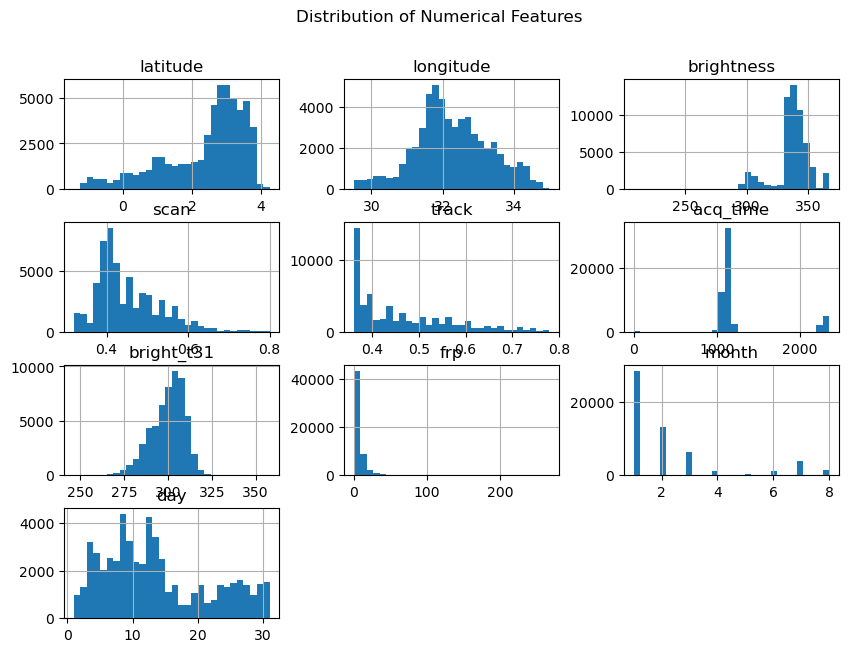

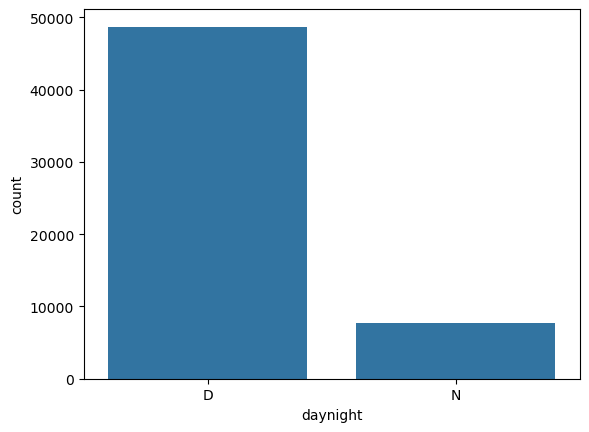

In [14]:
df.hist(figsize=(10, 7), bins=30)
plt.suptitle('Distribution of Numerical Features')
plt.show()

sns.countplot(x='daynight', data=df)
plt.show()

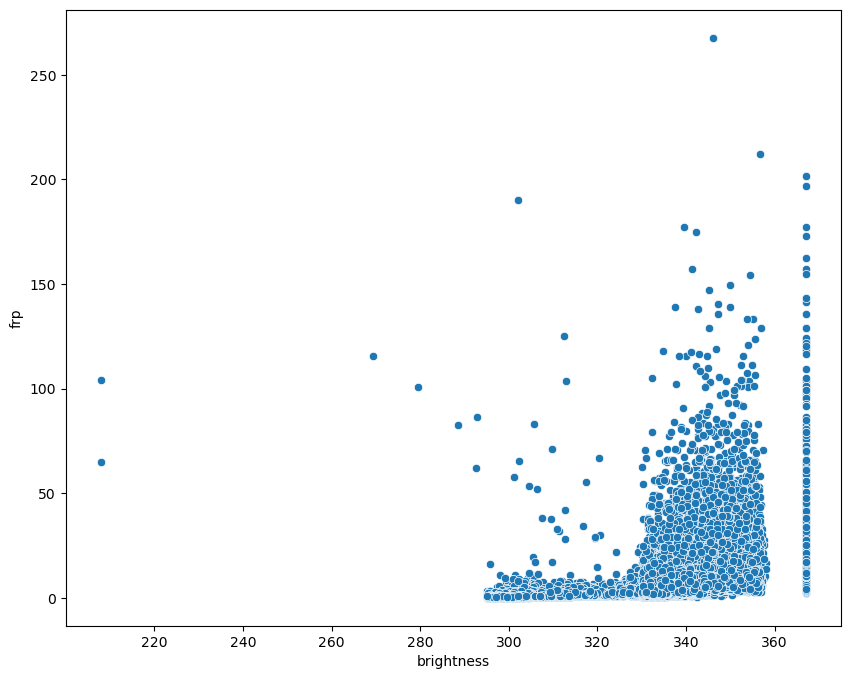

In [15]:
# Scatter plot for 'brightness' vs 'frp'
plt.figure(figsize=(10, 8))
sns.scatterplot(x='brightness', y='frp', data=df)
plt.show()



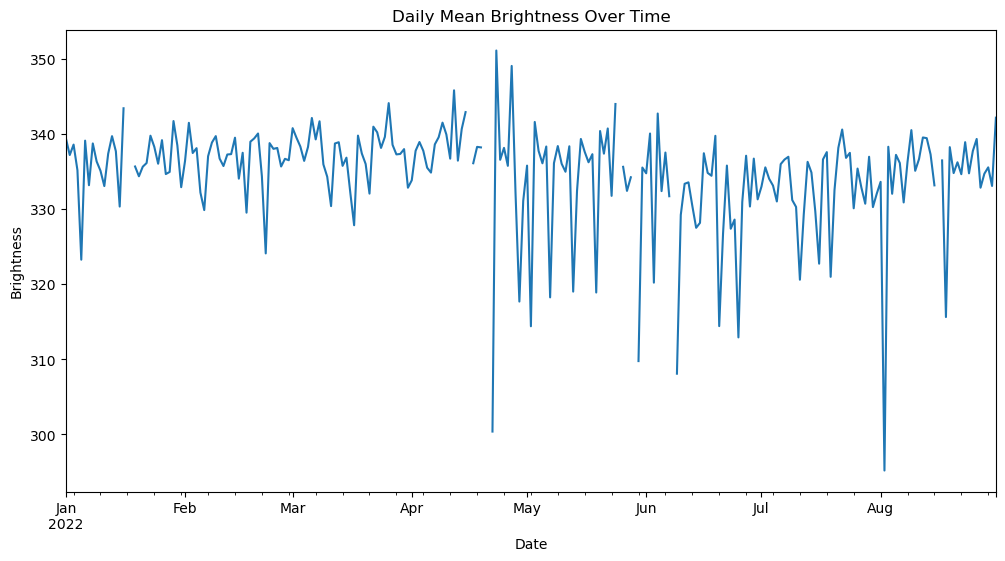

In [16]:
plt.figure(figsize=(12, 6))
df['brightness'].resample('D').mean().plot(title='Daily Mean Brightness Over Time')
plt.xlabel('Date')
plt.ylabel('Brightness')
plt.show()


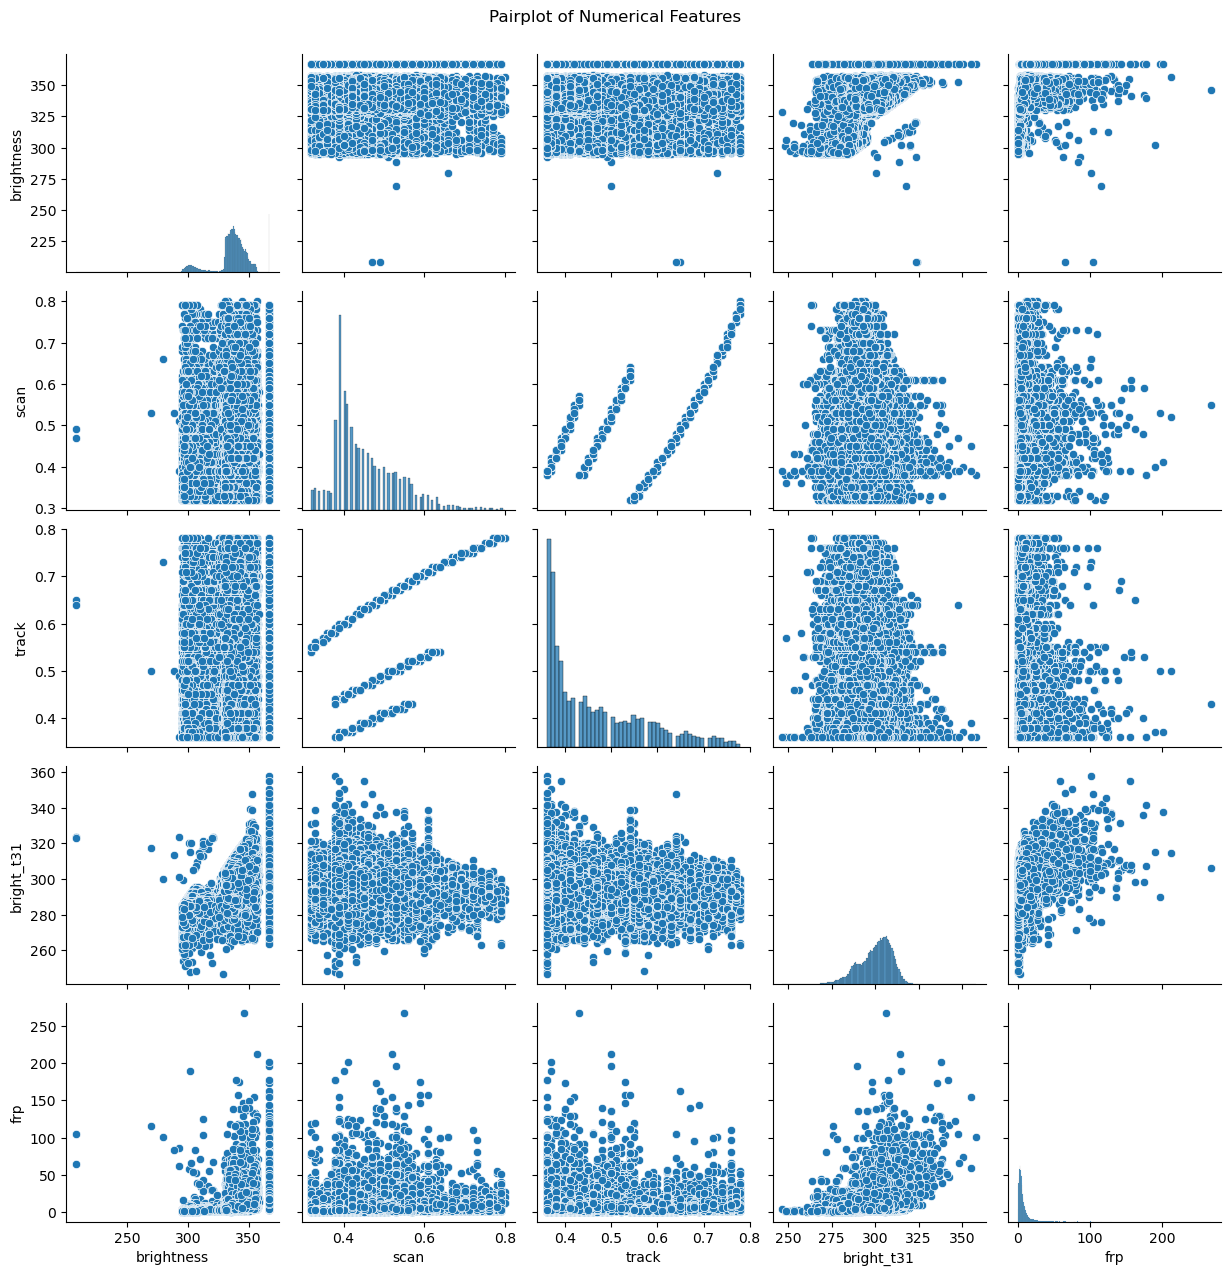

In [17]:
numerical_features = ['brightness', 'scan', 'track', 'bright_t31', 'frp']
sns.pairplot(df[numerical_features])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56369 entries, 2022-01-01 to 2022-08-31
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    56369 non-null  float64
 1   longitude   56369 non-null  float64
 2   brightness  56369 non-null  float64
 3   scan        56369 non-null  float64
 4   track       56369 non-null  float64
 5   acq_time    56369 non-null  int64  
 6   confidence  56369 non-null  object 
 7   bright_t31  56369 non-null  float64
 8   frp         56369 non-null  float64
 9   daynight    56369 non-null  object 
 10  month       56369 non-null  int32  
 11  day         56369 non-null  int32  
dtypes: float64(7), int32(2), int64(1), object(2)
memory usage: 5.2+ MB


### EDA for categorical Features

Frequency Distribution of confidence:
confidence
n    45732
l     8598
h     2039
Name: count, dtype: int64


Frequency Distribution of daynight:
daynight
D    48712
N     7657
Name: count, dtype: int64




C:\Users\moham\AppData\Local\Temp\ipykernel_24668\1460266105.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




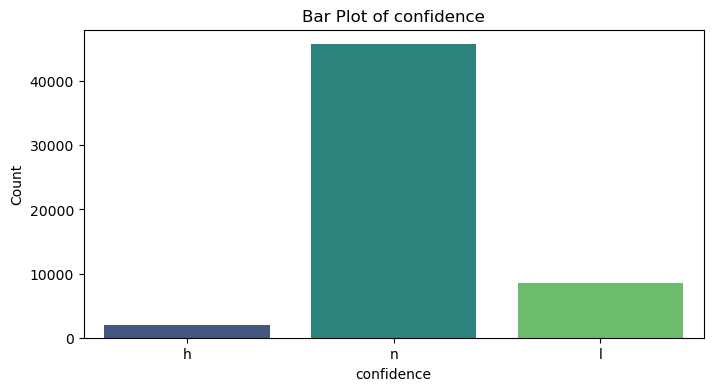

C:\Users\moham\AppData\Local\Temp\ipykernel_24668\1460266105.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




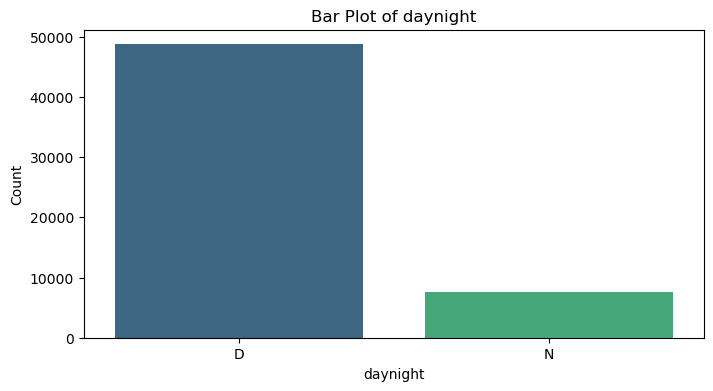

Cross-Tabulation:
daynight        D     N
confidence             
h            2016    23
l            8598     0
n           38098  7634




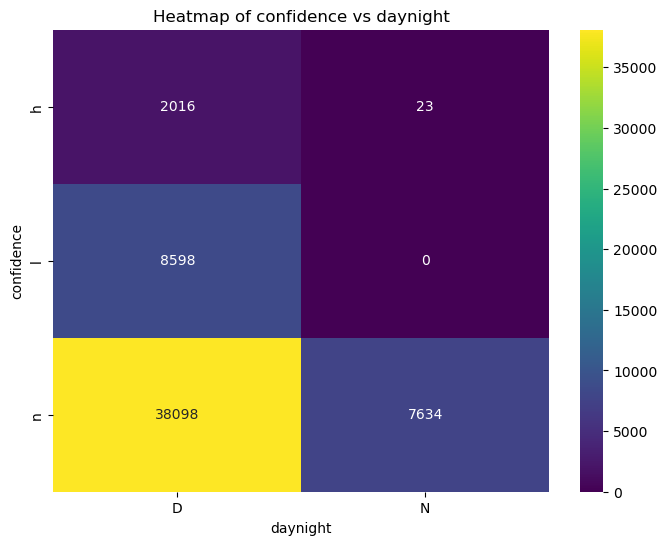

C:\Users\moham\AppData\Local\Temp\ipykernel_24668\1460266105.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




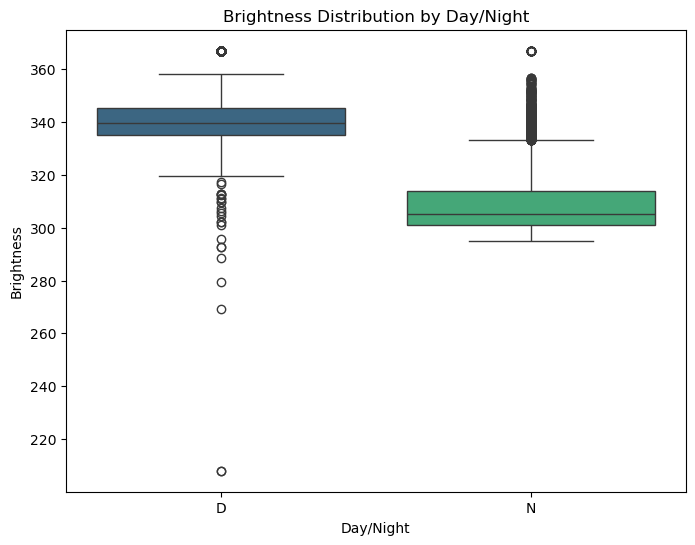

Chi-Square Test for confidence and daynight:
Chi2 Statistic: 1997.6208675449118, p-value: 0.0
There is a significant relationship between the two categorical features.


In [19]:
categorical_columns = ['confidence', 'daynight']
# 1. Frequency Distribution of Categorical Features
for col in categorical_columns:
    print(f"Frequency Distribution of {col}:")
    print(df[col].value_counts())
    print("\n")

# 2. Bar Plots for Categorical Features
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Bar Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


# 3. Cross-Tabulation (Relationship Between Two Categorical Features)
if len(categorical_columns) > 1:
    cross_tab = pd.crosstab(df[categorical_columns[0]], df[categorical_columns[1]])
    print("Cross-Tabulation:")
    print(cross_tab)
    print("\n")

    # Heatmap for Cross-Tabulation
    plt.figure(figsize=(8, 6))
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Heatmap of {categorical_columns[0]} vs {categorical_columns[1]}')
    plt.show()

# 4. Grouped Analysis (Categorical vs Numerical)
# Example: Compare 'brightness' across categories of 'daynight'
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='daynight', y='brightness', palette='viridis')
plt.title('Brightness Distribution by Day/Night')
plt.xlabel('Day/Night')
plt.ylabel('Brightness')
plt.show()

# 5. Chi-Square Test for Independence (Optional)
# To check if there's a significant relationship between two categorical features
from scipy.stats import chi2_contingency

if len(categorical_columns) > 1:
    chi2, p, dof, expected = chi2_contingency(cross_tab)
    print(f"Chi-Square Test for {categorical_columns[0]} and {categorical_columns[1]}:")
    print(f"Chi2 Statistic: {chi2}, p-value: {p}")
    if p < 0.05:
        print("There is a significant relationship between the two categorical features.")
    else:
        print("There is no significant relationship between the two categorical features.")

C:\Users\moham\AppData\Local\Temp\ipykernel_24668\3949038448.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




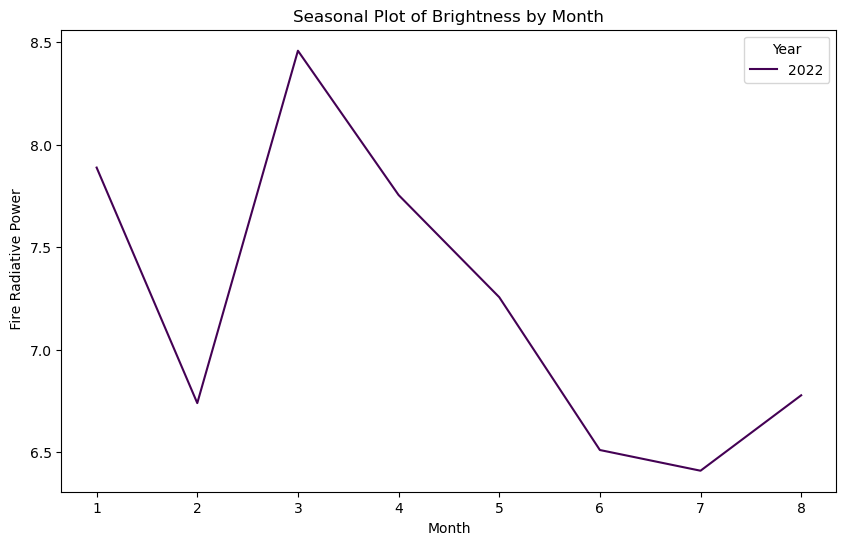

In [20]:
# Create a seasonal plot of frp by month

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month', y='frp', hue=df.index.year, palette='viridis', ci=None)
plt.title('Seasonal Plot of Brightness by Month')
plt.xlabel('Month')
plt.ylabel(' Fire Radiative Power')
plt.legend(title='Year')
plt.show()

# Preprocessing part

In [21]:
confidence_mapping = {'l': 0, 'n': 1, 'h': 2} # Define mapping for 'confidence' feature
df['confidence_encoded'] = df['confidence'].map(confidence_mapping) # Encode 'confidence' feature

In [22]:
daynight_mapping = {'D': 1, 'N': 0} # Define mapping for 'daynight' feature
df['daynight_encoded'] = df['daynight'].map(daynight_mapping) # Encode 'daynight' feature

In [23]:
df.head()

latitude  longitude  brightness  scan  track  acq_time confidence  \
acq_date                                                                        
2022-01-01  1.895509  31.501383      367.00  0.60   0.53      1148          h   
2022-01-01  1.691601  34.326340      333.38  0.47   0.64      1148          n   
2022-01-01  1.690971  34.322052      367.00  0.47   0.64      1148          h   
2022-01-01  1.685041  34.322899      331.16  0.47   0.64      1148          n   
2022-01-01  1.675683  34.341782      335.44  0.47   0.64      1148          n   

            bright_t31    frp daynight  month  day  confidence_encoded  \
acq_date                                                                 
2022-01-01      296.36  22.37        D      1    1                   2   
2022-01-01      291.38   6.77        D      1    1                   1   
2022-01-01      293.82   6.77        D      1    1                   2   
2022-01-01      292.69   6.77        D      1    1                   1   
2022-01-01      293.79   4.65        D      1    1                   1   

            daynight_encoded  
acq_date                      
2022-01-01                 1  
2022-01-01                 1  
2022-01-01                 1  
2022-01-01                 1  
2022-01-01                 1

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56369 entries, 2022-01-01 to 2022-08-31
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            56369 non-null  float64
 1   longitude           56369 non-null  float64
 2   brightness          56369 non-null  float64
 3   scan                56369 non-null  float64
 4   track               56369 non-null  float64
 5   acq_time            56369 non-null  int64  
 6   confidence          56369 non-null  object 
 7   bright_t31          56369 non-null  float64
 8   frp                 56369 non-null  float64
 9   daynight            56369 non-null  object 
 10  month               56369 non-null  int32  
 11  day                 56369 non-null  int32  
 12  confidence_encoded  56369 non-null  int64  
 13  daynight_encoded    56369 non-null  int64  
dtypes: float64(7), int32(2), int64(3), object(2)
memory usage: 6.0+ MB


            latitude  longitude  brightness      scan     track     acq_time  \
acq_date                                                                       
2022-01-01  2.970257  32.546034  339.422771  0.430669  0.576210  1263.605096   
2022-01-02  2.841309  32.557033  337.202969  0.482904  0.455328  1249.393013   
2022-01-03  2.991421  32.605523  338.592186  0.396428  0.383080  1191.643233   
2022-01-04  3.106642  32.519500  335.181908  0.464082  0.436263  1249.889764   
2022-01-05  2.637042  32.349574  323.263154  0.423496  0.484715  1721.157724   

            bright_t31       frp  confidence_encoded  daynight_encoded  \
acq_date                                                                 
2022-01-01  295.033981  7.169522            1.085987          0.894904   
2022-01-02  300.243777  9.252140            0.917031          0.890830   
2022-01-03  304.900536  7.986858            0.781923          0.908178   
2022-01-04  295.779534  7.483337            0.967898          0.84252

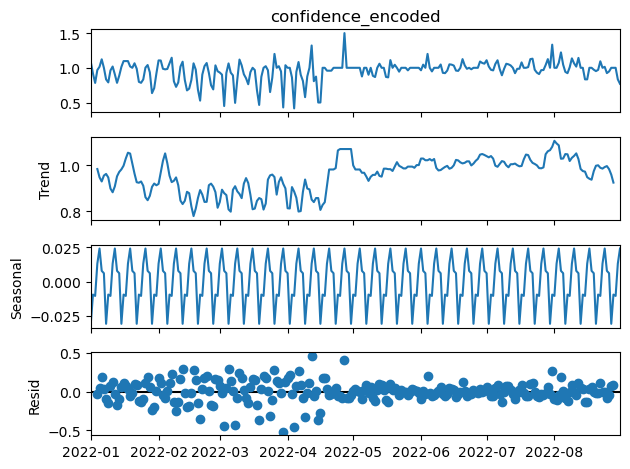

In [25]:
# 1. Ensure the DataFrame is sorted by the datetime index
df = df.sort_index()

# 2. Drop unnecessary or unrelated columns for ARIMA
columns_to_drop = ['confidence', 'daynight', 'month', 'day']
df = df.drop(columns=columns_to_drop, axis = 1) 

# 3. Resample data to ensure consistent time intervals (e.g., daily)
df = df.resample('D').mean()

# 4. Handle missing values after resampling
df = df.ffill()  # Forward fill again after resampling

# 5. Stationarity check and differentiation (if required for ARIMA)
# Ensure the target feature ('confidence_encoded') is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['confidence_encoded'])
if result[1] > 0.05:  # If p-value > 0.05, apply differencing
    df['confidence_encoded_diff'] = df['confidence_encoded'].diff().dropna()

# 6. Optional: Decompose the time series for analysis
# This step helps visualize trends, seasonality, and residuals
decomposition = seasonal_decompose(df['confidence_encoded'], model='additive')
decomposition.plot()

# Final preprocessed DataFrame
print(df.head())

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='brightness'>)

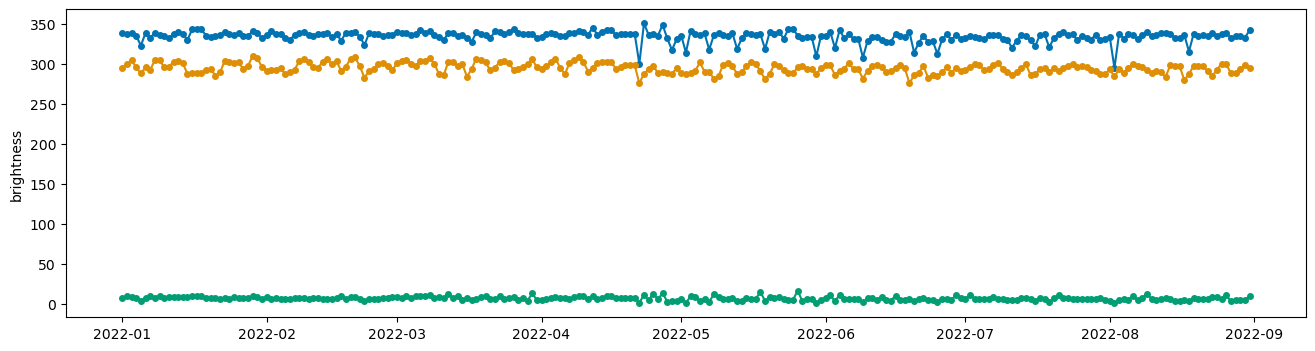

In [26]:
plot_series(df.brightness, df.bright_t31, df.frp)

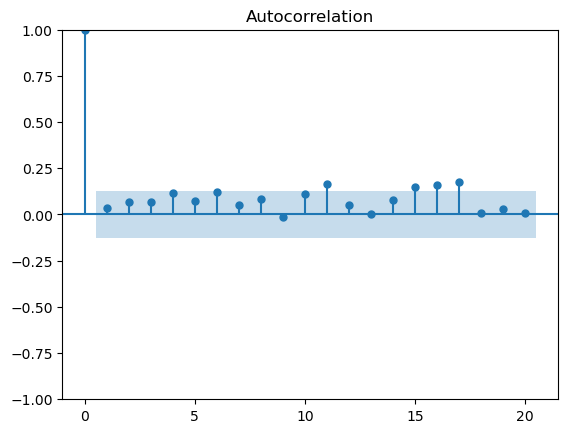

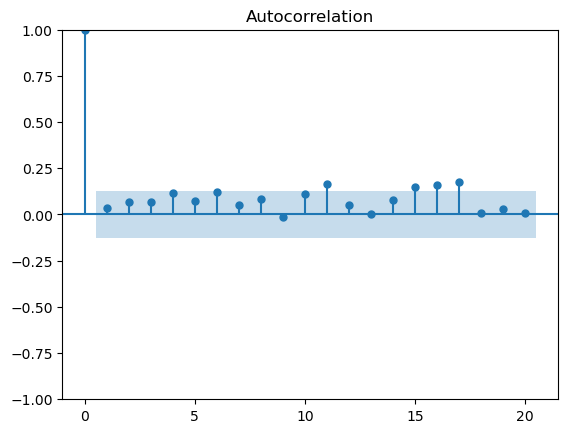

In [27]:
plot_acf(df.brightness, lags=20, bartlett_confint=False)

(<Figure size 800x1200 with 6 Axes>,
 array([<Axes: xlabel='y(t)', ylabel='y(t + 1)'>,
        <Axes: xlabel='y(t)', ylabel='y(t + 3)'>,
        <Axes: xlabel='y(t)', ylabel='y(t + 6)'>,
        <Axes: xlabel='y(t)', ylabel='y(t + 12)'>, <Axes: >, <Axes: >],
       dtype=object))

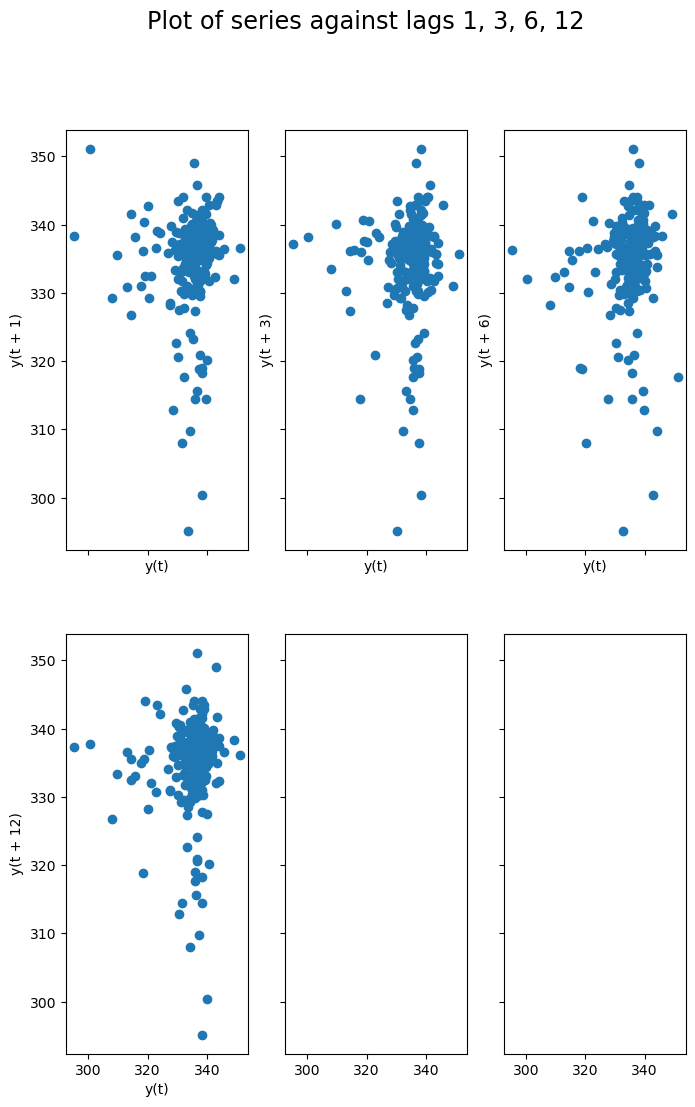

In [28]:
plot_lags(df.brightness, lags=[1, 3, 6, 12])

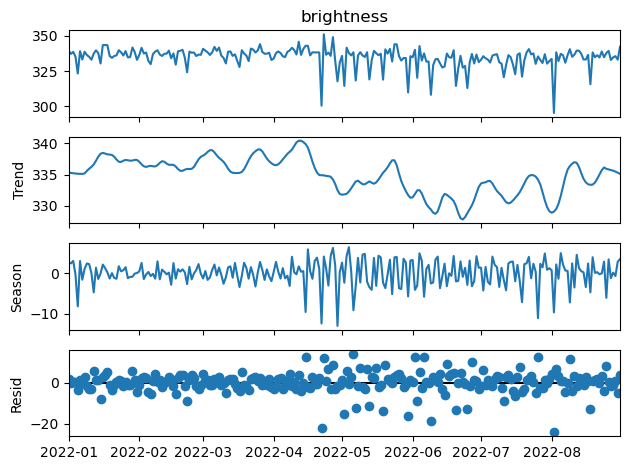

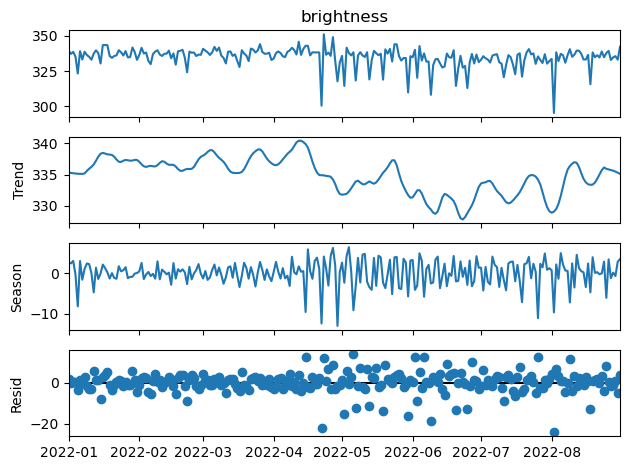

In [29]:
from statsmodels.tsa.api import STL

decomp = STL(df.brightness).fit()
decomp.plot()

In [30]:
def plot_ma(series, ms: list[int]):
    f = go.Figure()
    f.add_trace(go.Scatter(x=series.index, y=series, name='Original'))
    for m in ms:
        f.add_trace(go.Scatter(x=series.iloc[m:-m].index, y=series.rolling(m, center=True).mean(), name=f'{m}-MA'))
    return f
plot_ma(df.brightness, [3, 5])

In [31]:
px.line(x=df.index.month, y=df.brightness, color=df.index.year, title='Overlaid Seasonal Plot of Brightness')

In [32]:
resampled_df = df.resample('D').mean()

In [34]:
resampled_df['confidence_encoded_diff'] = resampled_df['confidence_encoded_diff'].bfill()
resampled_df

latitude  longitude  brightness      scan     track     acq_time  \
2022-01-01  2.970257  32.546034  339.422771  0.430669  0.576210  1263.605096   
2022-01-02  2.841309  32.557033  337.202969  0.482904  0.455328  1249.393013   
2022-01-03  2.991421  32.605523  338.592186  0.396428  0.383080  1191.643233   
2022-01-04  3.106642  32.519500  335.181908  0.464082  0.436263  1249.889764   
2022-01-05  2.637042  32.349574  323.263154  0.423496  0.484715  1721.157724   
...              ...        ...         ...       ...       ...          ...   
2022-08-27 -0.887436  31.695335  332.850000  0.330000  0.550000  1042.000000   
2022-08-28 -0.256779  29.896961  334.716667  0.463333  0.636667  1206.000000   
2022-08-29  1.522661  31.948386  335.560000  0.390000  0.547500  1148.000000   
2022-08-30  1.714592  31.908059  333.083333  0.496667  0.405000  1129.000000   
2022-08-31  0.232223  31.946529  342.178846  0.409615  0.372692  1106.461538   

            bright_t31       frp  confidence_encoded  daynight_encoded  \
2022-01-01  295.033981  7.169522            1.085987          0.894904   
2022-01-02  300.243777  9.252140            0.917031          0.890830   
2022-01-03  304.900536  7.986858            0.781923          0.908178   
2022-01-04  295.779534  7.483337            0.967898          0.842520   
2022-01-05  288.303610  3.525740            1.014634          0.463415   
...                ...       ...                 ...               ...   
2022-08-27  288.370000  3.000000            1.000000          1.000000   
2022-08-28  289.146667  4.903333            1.000000          1.000000   
2022-08-29  293.602500  4.460000            1.000000          1.000000   
2022-08-30  298.766667  4.516667            0.833333          1.000000   
2022-08-31  295.640385  9.434231            0.769231          1.000000   

            confidence_encoded_diff  
2022-01-01                -0.168957  
2022-01-02                -0.168957  
2022-01-03                -0.135108  
2022-01-04                 0.185976  
2022-01-05                 0.046736  
...                             ...  
2022-08-27                 0.052632  
2022-08-28                 0.000000  
2022-08-29                 0.000000  
2022-08-30                -0.166667  
2022-08-31                -0.064103  

[243 rows x 11 columns]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-221.205, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-121.490, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-124.219, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-183.534, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-123.489, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-216.252, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-227.533, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-226.320, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-266.540, Time=0.47 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-256.468, Time=0.29 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-264.284, Time=0.49 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-268.684, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-

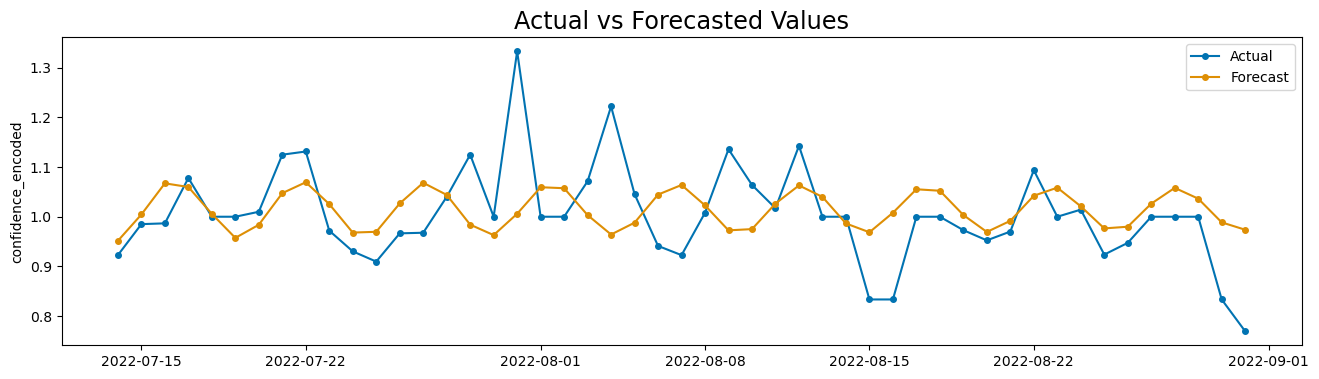

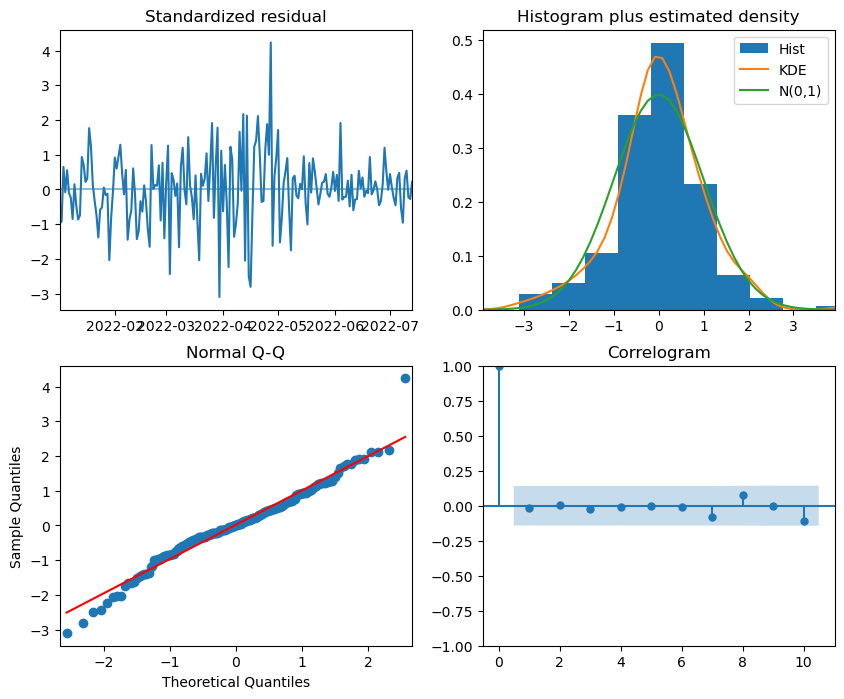

In [35]:
def optimize_arima_and_forecast(resampled_df, target_column, seasonal=False, m=1, test_size=0.2):
    """
    Optimize ARIMA hyperparameters and forecast the target column.

    Parameters:
        resampled_df (pd.DataFrame): Time series data with a DateTime index.
        target_column (str): Column to forecast ('confidence_encoded' or 'confidence_encoded_diff').
        test_size (float): Proportion of the dataset to include in the test split.
        seasonal (bool): Whether to consider seasonality in ARIMA.
        m (int): Seasonal periodicity (used if seasonal=True).
    
    Returns:
        dict: Dictionary containing model, evaluation metrics, and forecasts.
    """

    # Split into train and test sets
    y_train, y_test = temporal_train_test_split(resampled_df, test_size=test_size)
    train, test = y_train[target_column], y_test[target_column]

    # Auto ARIMA to find optimal (p, d, q) parameters
    model = auto_arima(
        train,
        seasonal=seasonal,
        m=m,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        trace=True
    )

    # Fit the ARIMA model
    model.fit(train)

    # Forecast the test set
    n_periods = len(test)  # Convert test_size to an integer
    forecasts = model.predict(n_periods=n_periods)

    # Evaluate the model
    mae = mean_absolute_error(test, forecasts)
    mse = mean_squared_error(test, forecasts)
    rmse = np.sqrt(mse)

    # Output results
    return {
        "model": model,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "forecasts": forecasts,
        "actuals": test
    }


# Forecast confidence_encoded
result = optimize_arima_and_forecast(resampled_df, target_column='confidence_encoded')

# Display results
print("Best ARIMA model:", result["model"])
print("MAE:", result["mae"])
print("Forecasts:", result["forecasts"])
print("Actual values:", result["actuals"])

# Plot actual vs forecasted values
plot_series(
    result["actuals"], 
    result["forecasts"],
    labels=["Actual", "Forecast"],
    title="Actual vs Forecasted Values"
)

# Show the plot
plt.show()

# Plot diagnostics for the ARIMA model
result["model"].plot_diagnostics(figsize=(10, 8))
plt.show()

In [114]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


2025-01-26 23:14:06.289 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 23:14:06.423 
  command:

    streamlit run c:\Users\moham\anaconda3\envs\env-ids\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-01-26 23:14:06.423 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 23:14:06.423 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 23:14:06.423 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 23:14:06.423 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 23:14:06.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 23:14:06.438 Thread 'Ma